# Exploring the spectral simulator

#### In the following we are going to simulate some spectra using the QC's and perform the same analysis on them, then compare the results.

The generate_spectra function looks as follows:

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov  6 18:28:01 2021

@author: eissa
"""

import numpy as np

def generate_spectra_v1(X, y, d, n_neg, n_pos, beta_neg_std='auto', beta_pos_std='auto', epsilon_std=0, random_state=42):
    """
    | Parameters |
    --------------
    X : 2-D Array
        Spectra matrix with observations in rows and wavenumbers in columns.
        Matrix models the intrinsic variability around the generated samples.
    y : 1-D Array
        A vector of sample labels: 0 for controls, 1 for cases. 
        Length is equal to the number of rows in X.
    d : 1-D Array
        Discriminant vector across the wavenumbers.
        Vector models the differences in means between the postive and negative class samples across the wavenumbers.
    n_pos : Int
        Number of positive class samples to be generated.
    n_neg : Int
        Number of negative class samples to be generated.
    beta_neg_std : Float
        Standard deviation around the biological variability of the negative class samples. 
        The higher, the more variance with zero being no variance.
        Defaults to sqrt(X_neg.shape[0]), i.e., the number of negative class samples used for calibration.
    beta_pos_std : Float
        Standard deviation around the biological variability of the positive class samples. 
        The higher, the more variance with zero being no variance.
        Defaults to sqrt(X_pos.shape[0]), i.e., the number of positive class samples used for calibration.
    epsilon_std : 1-D Array
        Standard deviation around the additative white noise across the spectrum. 
        The higher, the more variance with zero being no variance.
    random_state : Int or None
        Controls the pseudo-random number generator's random seed. 
        Pass an int for reproducible results across multiple runs with the same parameters.
    | Returns |
    -----------
    Y_gen : 2-D Matrix
        Generated spectra with n_neg+n_pos observations.
    class_labels : 1-D Vector
        Labels of generated spectra.
    """
    
    # Set random state
    rand = np.random.RandomState(random_state)

    # Create a matrix for each class
    X_neg = np.array(X[y==0])
    X_pos = np.array(X[y==1])

    # Mean class vectors
    mu_neg = X_neg.mean(axis=0)
    mu_pos = X_pos.mean(axis=0)

    # Difference matrix for each class (i.e. matrix of individual differential fingerprints)
    B_neg = X_neg - np.tile(mu_neg, (X_neg.shape[0], 1))
    B_pos = X_pos - np.tile(mu_pos, (X_pos.shape[0], 1))

    # Calibrate beta coef, if 'auto', to model the variability in the given samples
    if beta_neg_std == 'auto':
        beta_neg_std = np.sqrt(X_neg.shape[0])
    if beta_pos_std == 'auto':
        beta_pos_std = np.sqrt(X_pos.shape[0])

    # Generate class samples with modeled variability using the mean measurement of controls
    Y_neg_gen = np.tile(mu_neg, (n_neg, 1)) + rand.normal(0, beta_neg_std, (X_neg.shape[0], n_neg)).T @ (B_neg/X_neg.shape[0])
    Y_pos_gen = np.tile(mu_neg, (n_pos, 1)) + rand.normal(0, beta_pos_std, (X_pos.shape[0], n_pos)).T @ (B_pos/X_pos.shape[0])
    
    # Add discriminator vector to positive class
    Y_pos_gen += np.tile(d, (n_pos, 1))

    # Put generated samples in one matrix
    Y_gen = np.vstack([Y_neg_gen, Y_pos_gen])

    # Add technical noise
    Y_gen += rand.normal(0, epsilon_std, Y_gen.shape)
    
    # Create class labels for generated samples
    class_labels = np.hstack([np.zeros(n_neg), np.ones(n_pos)])
    
    return Y_gen, class_labels

Loading the data

In [2]:
import pandas as pd
import json as js

csv_path = "C:/Users/corinna.wegner/Documents/qcs.csv"
spectra_path = "//z-sv-dfsroot/dfsroot/project/agzigman/MIRA Anaylzer - Eval/L4L_all_samples/Serum"

data = pd.read_csv(csv_path, delimiter=",", header=0)
absorbances = []

for i in range(1, len(data)):
    ID = data["File Name"][i] + ".json"
    spectrum_path_id ="%s/%s"%(spectra_path,ID) 
    f = open(spectrum_path_id, "r")
    spect = js.loads(f.read())
    x = np.linspace(929.52720343237377,3050.8548461203636,len(spect["AB Data"]))
    ab_data = spect["AB Data"]
    ab_data = list(reversed(ab_data))
    absorbances.append(ab_data)

Now, we are producing our first simulated spectra.

C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_3544\3084292461.py:58: RuntimeWarning: Mean of empty slice.
  mu_pos = X_pos.mean(axis=0)


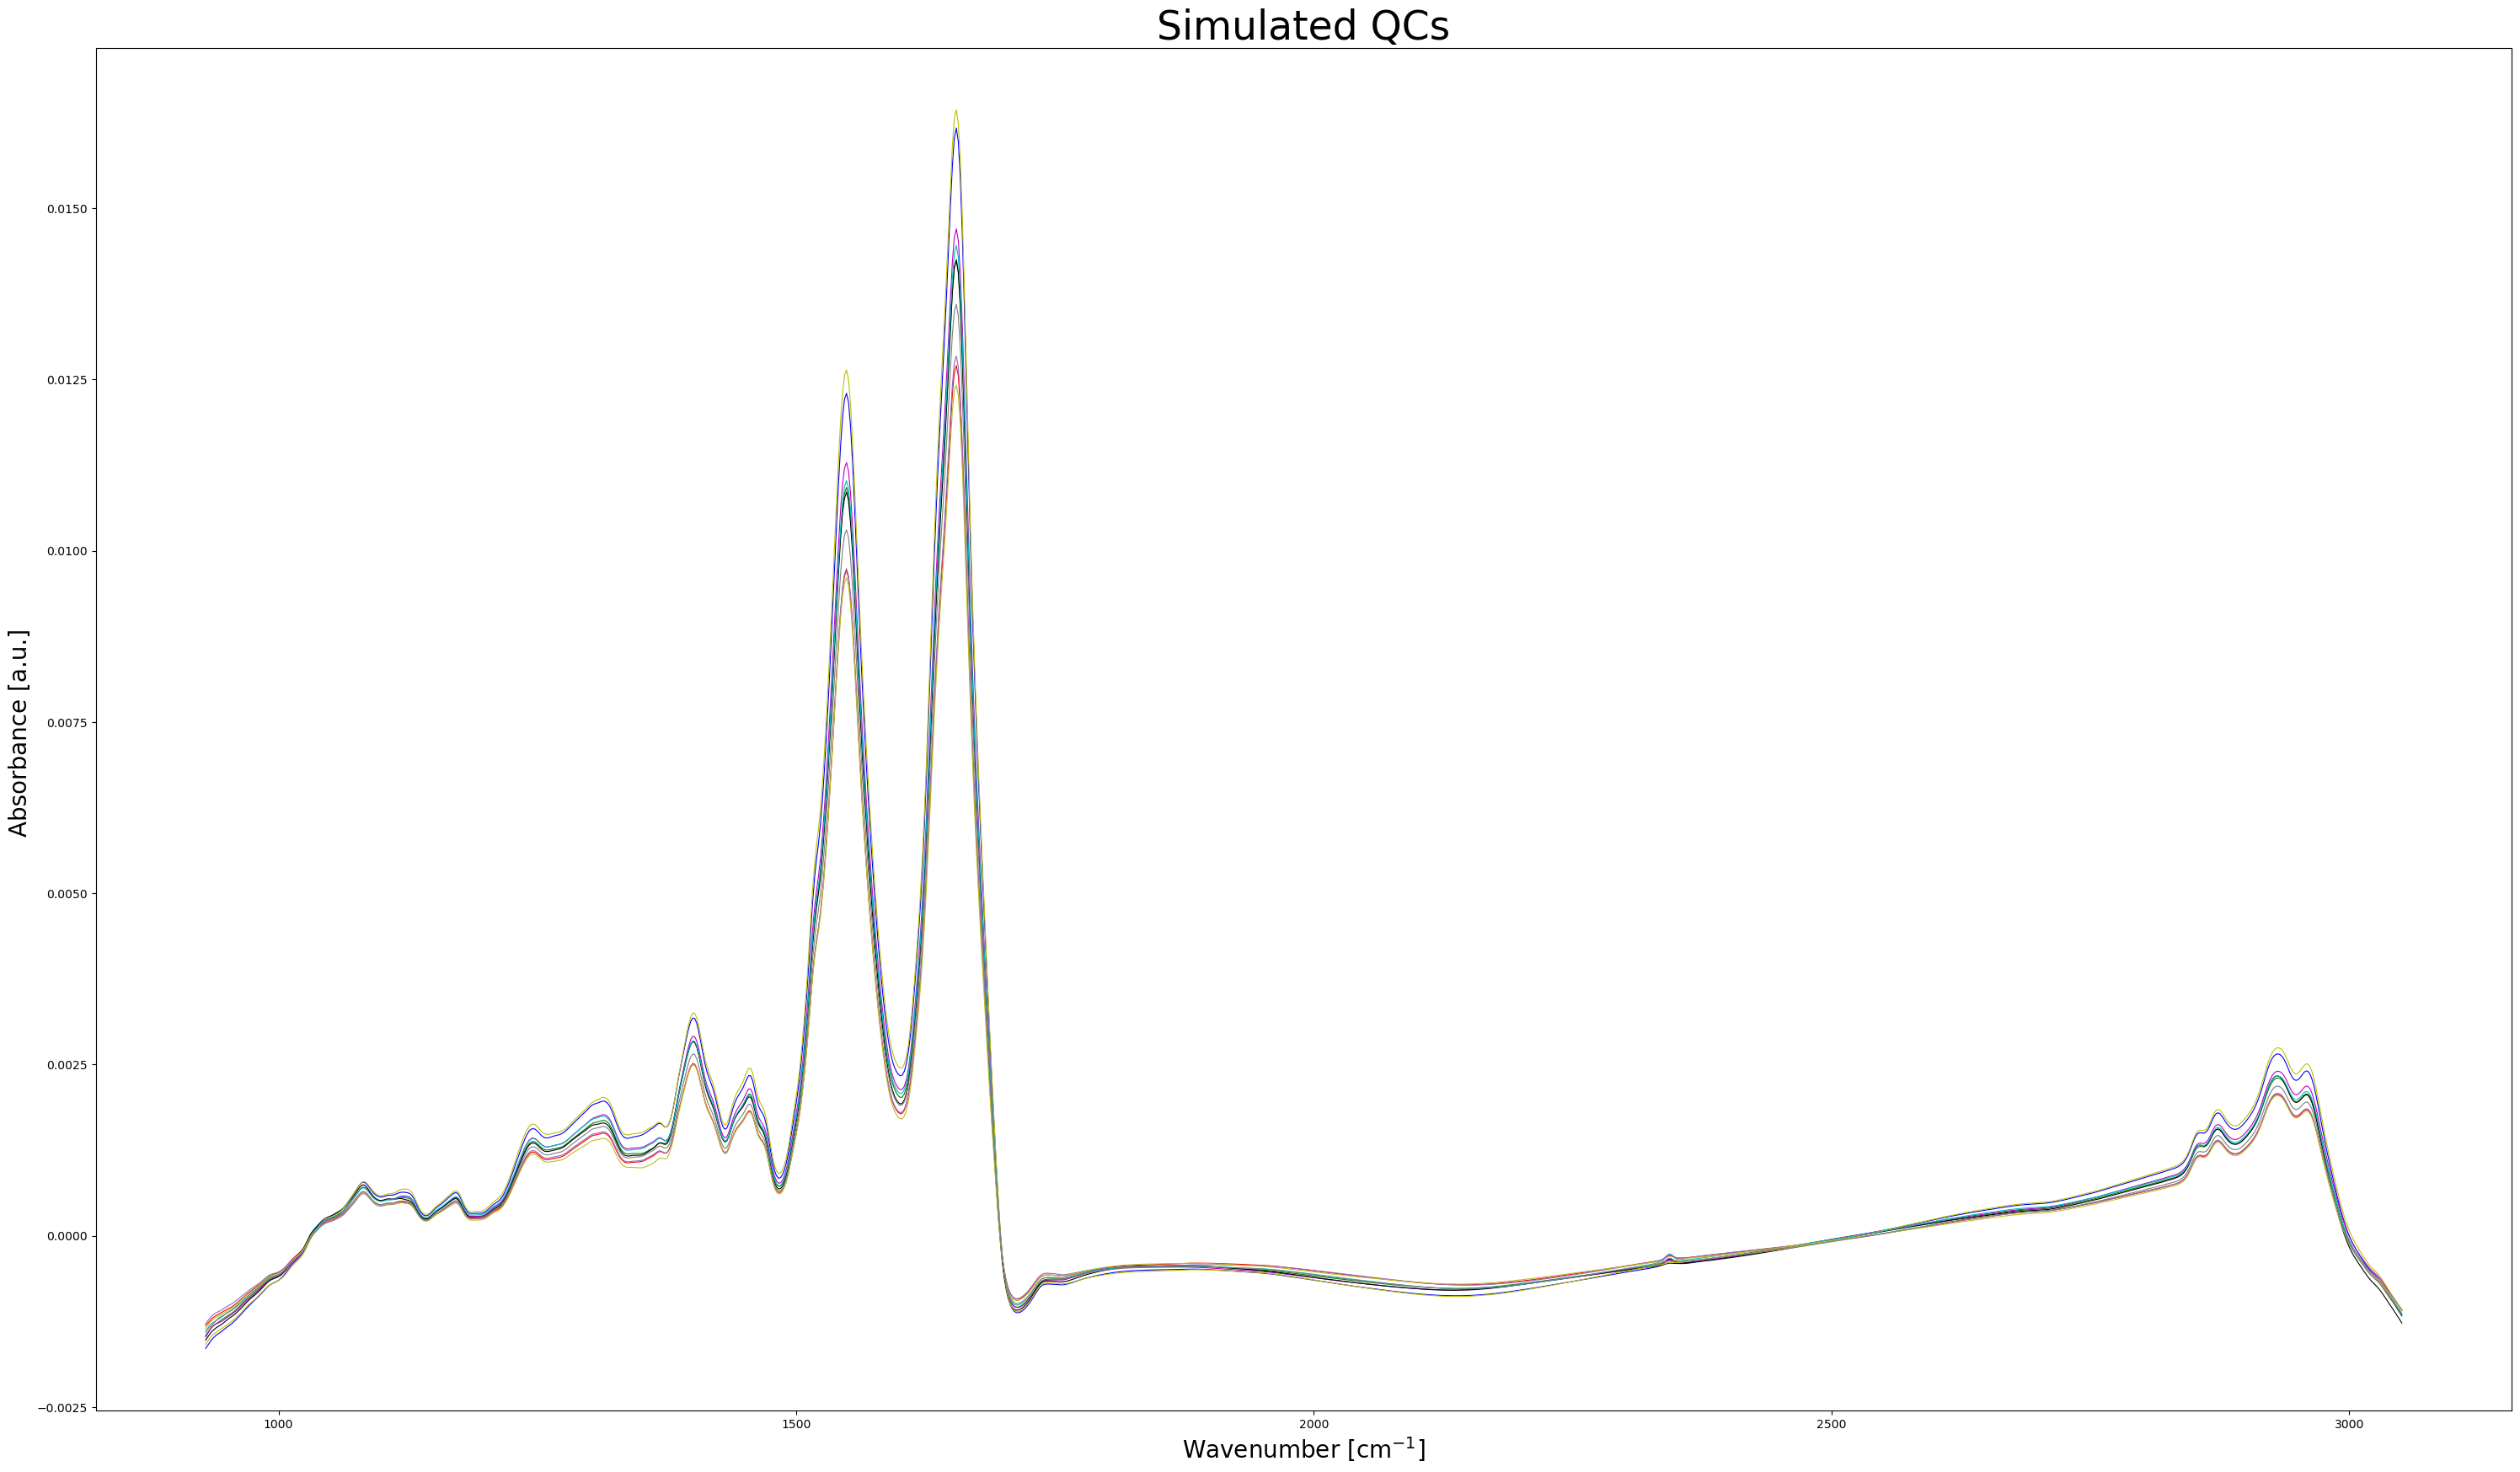

In [5]:
import matplotlib.pyplot as plt 

X = np.array(absorbances)
#np.savetxt("qcs_real.txt", X, delimiter=",", fmt='%1.18f')
y = np.zeros(X.shape[0])

X_gen, _ = generate_spectra_v1(X, y, d=0, n_neg=10, n_pos=0, beta_neg_std='auto', beta_pos_std='auto', epsilon_std=0, random_state=42)

xaxis = np.linspace(929.52720343237377,3050.8548461203636,X_gen.shape[1])
colors = ["r", "g", "b", "m", "k", "y", "c", "tab:purple", "tab:olive", "tab:gray"]
plt.figure(figsize= (18.5 * 2, 10.5 * 2))

for i in range(X_gen.shape[0]):
    plt.plot(xaxis, X_gen[i], colors[i] , linewidth= 0.8)
    
plt.xlabel("Wavenumber [cm$^{-1}$]", fontsize= 20) 
plt.ylabel("Absorbance [a.u.] ", fontsize=20)
plt.title("Simulated QCs", fontsize = 34)
plt.show()

Play around with random_state and epsilon_std,...

Now we want to generate a lot of spectra to do the analysis

In [6]:
X_gen_many, _ = generate_spectra_v1(X, y, d=0, n_neg=1500, n_pos=0, beta_neg_std='auto', beta_pos_std='auto', epsilon_std=0, random_state=42)
#print(X_gen_many.shape)
#np.savetxt("qcs_gen.txt", X_gen_many, delimiter=",", fmt='%1.18f')

C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_7456\3084292461.py:58: RuntimeWarning: Mean of empty slice.
  mu_pos = X_pos.mean(axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Using X_gen_many, we perform PCA:

Text(0, 0.5, 'principal component 2')

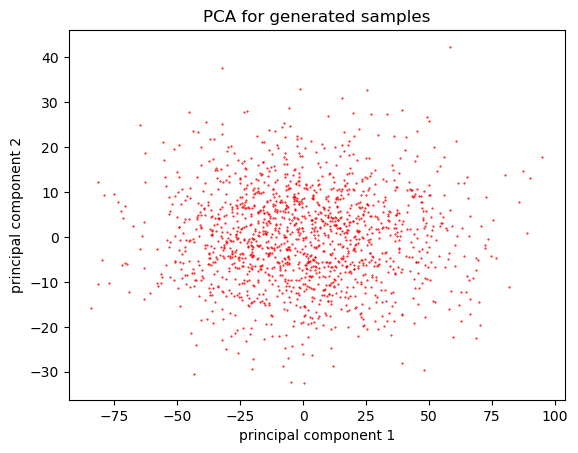

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_std = StandardScaler().fit_transform(X_gen_many)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

for i in range(len(principalDf)):
    if principalDf["principal component 1"][i] > 200:
        principalDf = principalDf.drop(i)

xaxis = list(principalDf["principal component 1"])
yaxis = list(principalDf["principal component 2"])

plt.plot(xaxis, yaxis, 'ro', markersize= 0.5)
plt.title("PCA for generated samples")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")

To compare the PCA's from, we plot them together 

Text(0, 0.5, 'principal component 2')

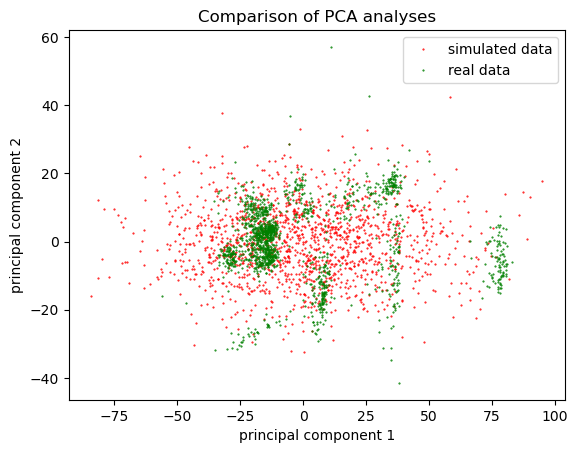

In [12]:
import numpy as np
x_qcs = np.loadtxt("pcax.txt")
y_qcs = np.loadtxt("pcay.txt")
plt.plot(xaxis, yaxis, 'ro', markersize = 0.5, label = "simulated data")
plt.plot(x_qcs, y_qcs, 'go', markersize = 0.5, label = "real data")
plt.title("Comparison of PCA")
plt.legend()
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
#plt.savefig("comparison_pca.png")

One can easily see the difference. While, for the real data, you can see different regions in which many data points accumulate, you cannot observe such behaviour for the simulated data. This is because the simulated data points are linear combinations of the real data, hence all properties of the real data are mixed in the simulated data.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 6.401608
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.942585
[t-SNE] KL divergence after 300 iterations: 1.183578


Text(0, 0.5, 'principal component 2')

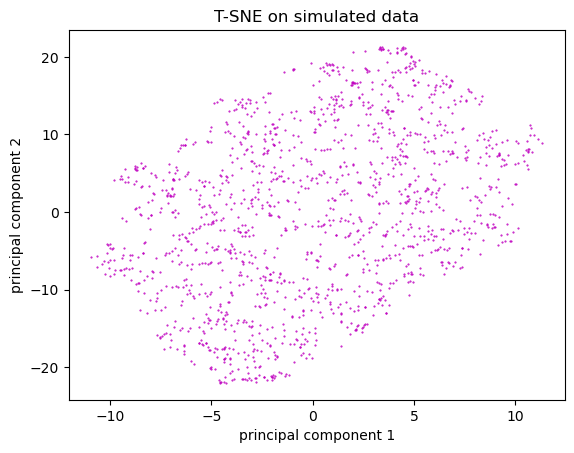

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

x_tsne = tsne_results[:,0]
y_tsne = tsne_results[:,1]
plt.plot(x_tsne, y_tsne, "mo", markersize = 0.5)
plt.title("T-SNE on simulated data")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")

Comparing to the analysis of the real data:

Text(35.347222222222214, 0.5, 'principal component 2')

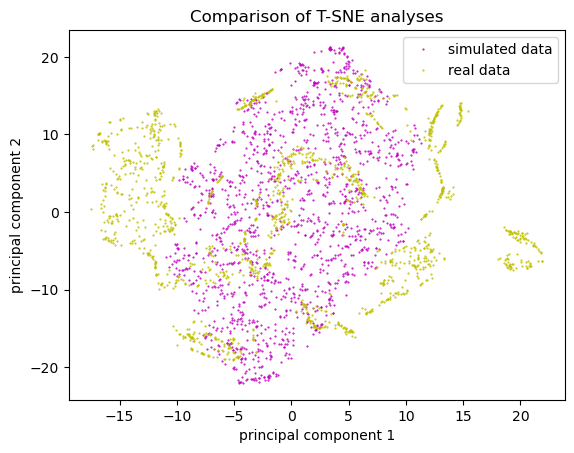

In [13]:
x_tqcs = np.loadtxt("tsnex.txt")
y_tqcs = np.loadtxt("tsney.txt")
plt.plot(x_tsne, y_tsne, 'mo', markersize = 0.5, label = "simulated data")
plt.plot(x_tqcs, y_tqcs, 'yo', markersize = 0.5, label = "real data")
plt.title("Comparison of T-SNE analyses")
plt.legend()
plt.savefig("comparison_tsne.png")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")

We observe the same as we have in the PCA comparison: The simulated data do not arrange into different regions but into one big cloud.

My questions: 
What is random_state?